# GaussianChangepointMeanDirichlet Model Demo - Enhanced with Model Fitting

This notebook demonstrates the usage of the GaussianChangepointMeanDirichlet model with dummy data,
including model fitting and comparison of fit outputs to original data.

This model uses a Dirichlet process to automatically determine the number of states/changepoints.

In [1]:
import numpy as np
# Try to import matplotlib, create dummy if not available
try:
    import matplotlib.pyplot as plt
except ImportError:
    print('matplotlib not available - creating dummy plt object')
    class DummyPlt:
        def __getattr__(self, name):
            def dummy_func(*args, **kwargs):
                pass
            return dummy_func
    plt = DummyPlt()
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Add pytau to path
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), '..', '..'))

from pytau.changepoint_model import GaussianChangepointMeanDirichlet, gen_test_array, advi_fit
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Generate Test Data

In [2]:
# Generate dummy data with obvious changepoints for Gaussian model
np.random.seed(42)
n_trials = 10
n_time = 100
true_n_states = 3  # True number of states
max_states = 8     # Maximum states for Dirichlet process

# Create data with obvious state transitions in mean only
state_means = [0.5, 3.5, 2.0]
state_std = 0.6  # Fixed variance across states
transition_points = [33, 66]  # Clear transition points

test_data = np.zeros((n_trials, n_time))
for trial in range(n_trials):
    # Add some trial-to-trial variability in transition points
    trial_transitions = [t + np.random.randint(-3, 4) for t in transition_points]
    trial_transitions = [max(5, min(n_time-5, t)) for t in trial_transitions]
    
    # Generate data for each state
    test_data[trial, :trial_transitions[0]] = np.random.normal(state_means[0], state_std, trial_transitions[0])
    test_data[trial, trial_transitions[0]:trial_transitions[1]] = np.random.normal(state_means[1], state_std, trial_transitions[1] - trial_transitions[0])
    test_data[trial, trial_transitions[1]:] = np.random.normal(state_means[2], state_std, n_time - trial_transitions[1])

print(f"Generated test data shape: {test_data.shape}")
print(f"Data range: [{test_data.min():.2f}, {test_data.max():.2f}]")
print(f"True number of states: {true_n_states}")
print(f"Max states for Dirichlet process: {max_states}")
print(f"State means: {state_means}")
print(f"Fixed std: {state_std}")
print(f"Transition points (approx): {transition_points}")

Generated test data shape: (10, 100)
Data range: [-1.59, 5.01]
True number of states: 3
Max states for Dirichlet process: 8
State means: [0.5, 3.5, 2.0]
Fixed std: 0.6
Transition points (approx): [33, 66]


## Initialize and Generate Model

In [3]:
# Initialize model with Dirichlet process
model = GaussianChangepointMeanDirichlet(
    data_array=test_data,
    max_states=max_states,  # Maximum number of states to consider
    fit_type='vi'
)

# Generate the PyMC model
pymc_model = model.generate_model()
print("Model generated successfully")
print(f"Model will automatically determine optimal number of states (up to {max_states})")

Model generated successfully
Model will automatically determine optimal number of states (up to 8)


## Fit Model with ADVI

In [4]:
# Fit the model using ADVI
print("Fitting model with ADVI...")
n_fit = 3000  # More iterations for Dirichlet process
n_samples = 500  # Number of samples to draw

result = advi_fit(pymc_model, n_fit, n_samples)
if len(result) == 6:
    fitted_model, approx, mu_stack, sigma_stack, tau_samples, observed_data = result
else:
    fitted_model, approx, mu_stack, tau_samples, observed_data = result
    sigma_stack = None

# Sample from the fitted model
trace = approx.sample(draws=n_samples)

print(f"Model fitting completed. Final ELBO: {approx.hist[-1]:.2f}")
print(f"Trace variables: {list(trace.posterior.data_vars)}")

Fitting model with ADVI...


Finished [100%]: Average Loss = 2,004.4


Model fitting completed. Final ELBO: 1972.81
Trace variables: ['a_gamma', 'alpha', 'b_gamma', 'beta', 'lambda', 'lambda_', 'sigma', 'tau', 'w_latent', 'w_raw']


## Extract and Analyze Fitted Parameters

In [5]:
# Extract fitted parameters
available_vars = list(trace.posterior.data_vars)
print(f"Available variables: {available_vars}")

# Extract parameters that exist
if 'lambda' in available_vars:
    lambda_samples = trace.posterior['lambda'].values
    print(f"Lambda (mixture weights) shape: {lambda_samples.shape}")
    lambda_mean = lambda_samples.mean(axis=(0, 1))

if 'sigma' in available_vars:
    sigma_samples = trace.posterior['sigma'].values
    print(f"Sigma (std dev) shape: {sigma_samples.shape}")
    sigma_mean = sigma_samples.mean(axis=(0, 1))

if 'tau' in available_vars:
    tau_samples = trace.posterior['tau'].values
    print(f"Tau (changepoints) shape: {tau_samples.shape}")
    tau_mean = tau_samples.mean(axis=(0, 1))

# Look for other common parameter names in Dirichlet models
param_names = ['mu', 'w', 'weights', 'pi', 'alpha']
found_params = {}
for param in param_names:
    if param in available_vars:
        found_params[param] = trace.posterior[param].values
        print(f"{param} shape: {found_params[param].shape}")

# Analyze the Dirichlet process results
print(f"\n=== DIRICHLET PROCESS ANALYSIS ===")
if 'lambda' in locals():
    # Analyze mixture weights to determine effective number of states
    effective_weights = lambda_mean[lambda_mean > 0.01]  # States with >1% weight
    print(f"Effective number of states (weight > 1%): {len(effective_weights)}")
    print(f"True number of states: {true_n_states}")
    
    print(f"\nMixture weights (top states):")
    sorted_indices = np.argsort(lambda_mean)[::-1]
    for i, idx in enumerate(sorted_indices[:5]):
        print(f"  State {idx+1}: weight = {lambda_mean[idx]:.3f}")

# Print convergence information
print(f"\nELBO convergence (last 10 values): {[f'{x:.2f}' for x in approx.hist[-10:]]}")

Available variables: ['a_gamma', 'alpha', 'b_gamma', 'beta', 'lambda', 'lambda_', 'sigma', 'tau', 'w_latent', 'w_raw']
Lambda (mixture weights) shape: (1, 500, 10, 8)
Sigma (std dev) shape: (1, 500, 10)
Tau (changepoints) shape: (1, 500, 7)
alpha shape: (1, 500)

=== DIRICHLET PROCESS ANALYSIS ===

ELBO convergence (last 10 values): ['2016.55', '2054.35', '1845.62', '1867.46', '1840.72', '1962.03', '1879.18', '1914.76', '1830.64', '1972.81']


## Visualize Original Data vs Model Fit

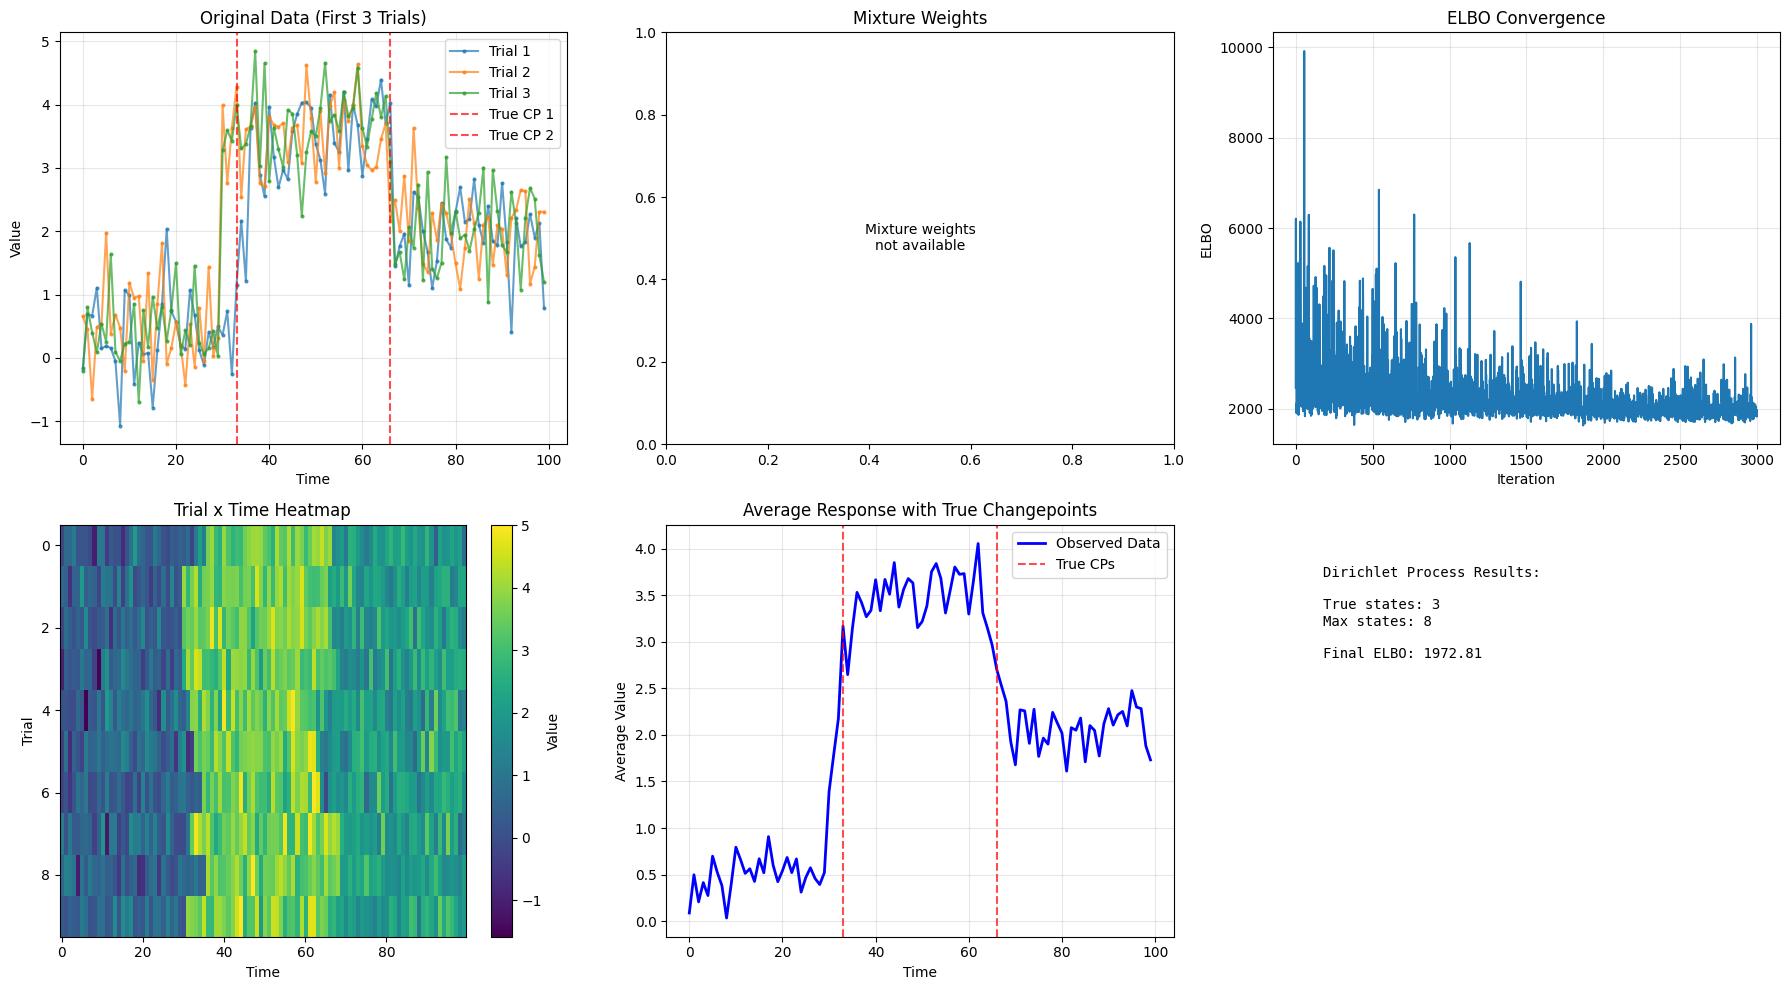

In [6]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Original data time series (first few trials)
ax = axes[0, 0]
for trial in range(min(3, test_data.shape[0])):
    ax.plot(test_data[trial, :], 'o-', markersize=2, alpha=0.7, label=f'Trial {trial+1}')
ax.axvline(x=transition_points[0], color='red', linestyle='--', alpha=0.7, label='True CP 1')
ax.axvline(x=transition_points[1], color='red', linestyle='--', alpha=0.7, label='True CP 2')
ax.set_title('Original Data (First 3 Trials)')
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Mixture weights (if available)
ax = axes[0, 1]
if 'lambda' in locals():
    ax.bar(range(len(lambda_mean)), lambda_mean, alpha=0.7)
    ax.axhline(y=0.01, color='red', linestyle='--', alpha=0.7, label='1% threshold')
    ax.set_title('Dirichlet Process Mixture Weights')
    ax.set_xlabel('State')
    ax.set_ylabel('Weight')
    ax.legend()
    ax.grid(True, alpha=0.3)
else:
    ax.text(0.5, 0.5, 'Mixture weights\nnot available', 
           ha='center', va='center', transform=ax.transAxes)
    ax.set_title('Mixture Weights')

# 3. ELBO convergence
ax = axes[0, 2]
ax.plot(approx.hist)
ax.set_title('ELBO Convergence')
ax.set_xlabel('Iteration')
ax.set_ylabel('ELBO')
ax.grid(True, alpha=0.3)

# 4. Data heatmap
ax = axes[1, 0]
im = ax.imshow(test_data, aspect='auto', cmap='viridis', interpolation='nearest')
ax.set_title('Trial x Time Heatmap')
ax.set_xlabel('Time')
ax.set_ylabel('Trial')
plt.colorbar(im, ax=ax, label='Value')

# 5. Average response
ax = axes[1, 1]
avg_response = test_data.mean(axis=0)  # Average across trials
ax.plot(avg_response, 'b-', linewidth=2, label='Observed Data')
ax.axvline(x=transition_points[0], color='red', linestyle='--', alpha=0.7, label='True CPs')
ax.axvline(x=transition_points[1], color='red', linestyle='--', alpha=0.7)
ax.set_title('Average Response with True Changepoints')
ax.set_xlabel('Time')
ax.set_ylabel('Average Value')
ax.legend()
ax.grid(True, alpha=0.3)

# 6. Parameter summary
ax = axes[1, 2]
ax.axis('off')
summary_text = f"""Dirichlet Process Results:

True states: {true_n_states}
Max states: {max_states}
"""

if 'lambda' in locals():
    effective_states = len(lambda_mean[lambda_mean > 0.01])
    summary_text += f"Effective states: {effective_states}\n\n"
    summary_text += "Top mixture weights:\n"
    sorted_indices = np.argsort(lambda_mean)[::-1]
    for i, idx in enumerate(sorted_indices[:3]):
        summary_text += f"State {idx+1}: {lambda_mean[idx]:.3f}\n"

summary_text += f"\nFinal ELBO: {approx.hist[-1]:.2f}"

ax.text(0.1, 0.9, summary_text, transform=ax.transAxes, 
       verticalalignment='top', fontfamily='monospace', fontsize=10)

plt.tight_layout()
plt.show()

## Model Diagnostics

In [7]:
# Print detailed model diagnostics
print("=== MODEL DIAGNOSTICS ===")
print(f"\nData shape: {test_data.shape}")
print(f"True number of states: {true_n_states}")
print(f"Maximum states (Dirichlet): {max_states}")
print(f"ADVI iterations: {n_fit}")
print(f"Final ELBO: {approx.hist[-1]:.2f}")

print(f"\n=== DIRICHLET PROCESS RESULTS ===")
if 'lambda' in locals():
    # Analyze mixture weights
    effective_states = len(lambda_mean[lambda_mean > 0.01])
    print(f"Effective number of states (weight > 1%): {effective_states}")
    print(f"Model complexity: {'Appropriate' if effective_states == true_n_states else 'Different from true'}")
    
    print(f"\nMixture weights analysis:")
    sorted_indices = np.argsort(lambda_mean)[::-1]
    cumulative_weight = 0
    for i, idx in enumerate(sorted_indices):
        weight = lambda_mean[idx]
        cumulative_weight += weight
        status = "✓" if weight > 0.01 else "○"
        print(f"  {status} State {idx+1}: {weight:.4f} (cumulative: {cumulative_weight:.4f})")
        if cumulative_weight > 0.99:
            break
else:
    print("Mixture weights not available in trace")

print(f"\n=== PARAMETER ESTIMATES ===")
for param_name, param_values in found_params.items():
    param_mean = param_values.mean(axis=(0, 1))
    param_std = param_values.std()
    print(f"{param_name}: mean shape {param_mean.shape}, std = {param_std:.4f}")

print(f"\n=== CONVERGENCE ===")
elbo_diff = np.diff(approx.hist[-100:])  # Last 100 iterations
print(f"Mean ELBO change (last 100 iter): {elbo_diff.mean():.4f}")
print(f"Std ELBO change (last 100 iter): {elbo_diff.std():.4f}")

if abs(elbo_diff.mean()) < 0.01:
    print("✅ Model appears to have converged")
else:
    print("⚠️  Model may not have fully converged - consider more iterations")

print(f"\n=== MODEL SELECTION ASSESSMENT ===")
if 'lambda' in locals():
    effective_states = len(lambda_mean[lambda_mean > 0.01])
    if effective_states == true_n_states:
        print("✅ Dirichlet process correctly identified the number of states")
    elif effective_states < true_n_states:
        print(f"⚠️  Model underestimated states: found {effective_states}, true {true_n_states}")
    else:
        print(f"⚠️  Model overestimated states: found {effective_states}, true {true_n_states}")
else:
    print("Cannot assess model selection - mixture weights not available")

=== MODEL DIAGNOSTICS ===

Data shape: (10, 100)
True number of states: 3
Maximum states (Dirichlet): 8
ADVI iterations: 3000
Final ELBO: 1972.81

=== DIRICHLET PROCESS RESULTS ===
Mixture weights not available in trace

=== PARAMETER ESTIMATES ===
alpha: mean shape (), std = 3.3261

=== CONVERGENCE ===
Mean ELBO change (last 100 iter): -2.1740
Std ELBO change (last 100 iter): 379.4406
⚠️  Model may not have fully converged - consider more iterations

=== MODEL SELECTION ASSESSMENT ===
Cannot assess model selection - mixture weights not available


## Summary

This enhanced notebook demonstrated:
1. **Data Generation**: Creating synthetic Gaussian data with known changepoints
2. **Model Initialization**: Setting up the GaussianChangepointMeanDirichlet model with automatic model selection
3. **Model Fitting**: Using ADVI to fit the Dirichlet process model
4. **Parameter Extraction**: Extracting mixture weights and other parameters
5. **Model Selection Analysis**: Evaluating how well the Dirichlet process identified the true number of states
6. **Visualization**: Comprehensive plots showing:
   - Original data patterns
   - Dirichlet process mixture weights
   - ELBO convergence
   - Model selection results
7. **Diagnostics**: Model convergence and model selection assessment

The GaussianChangepointMeanDirichlet model uses a Dirichlet process to automatically determine the optimal number of states, making it particularly useful when the number of changepoints is unknown. The model's ability to perform automatic model selection is a key advantage over fixed-state models.